We just read the video and make frames out of it.In the end just plot some images as we don not havet make a label data. 

# Data

In [2]:
import cv2 
import os 
import matplotlib.pyplot as plt

In [4]:
cam = cv2.VideoCapture("./data/final.mp4") 
#fig=plt.figure(figsize=(15, 15))

try: 
    if not os.path.exists('finaldata'): 
        os.makedirs('finaldata') 
except OSError: 
    print ('Error: Creating directory of data')
currentframe = 0
  
while(True): 
      
    
    ret,frame = cam.read() 
  
    if ret: 
        name = './finaldata/frame' + str(currentframe) + '.jpg'
        #plt.imshow(frame)
        cv2.imwrite(name, frame)
        currentframe += 1
    else: 
        break
cam.release() 
cv2.destroyAllWindows()

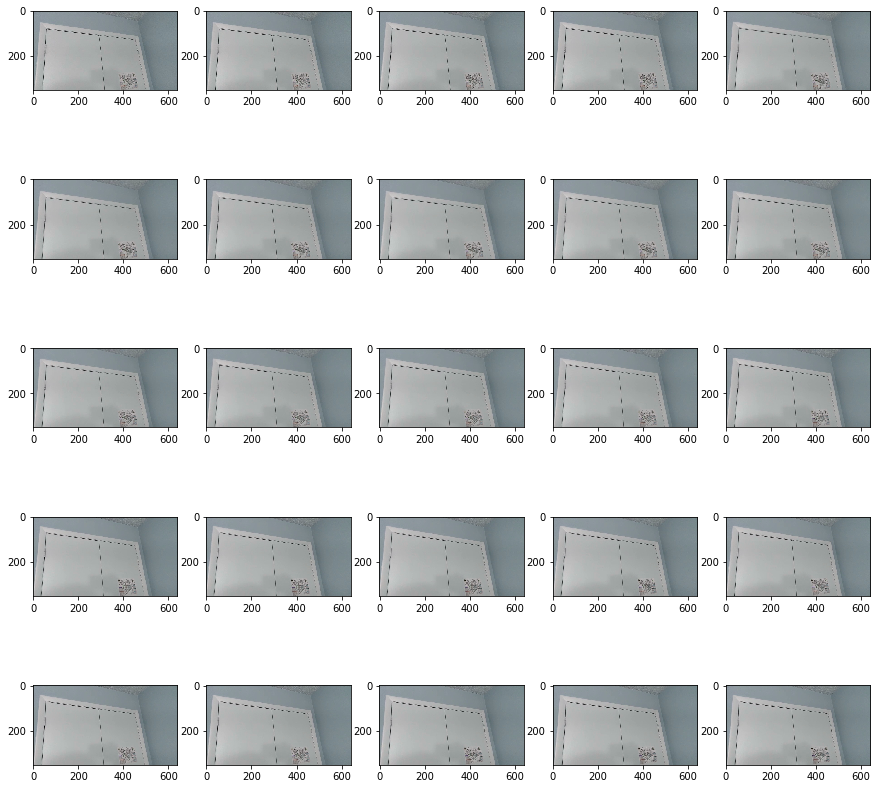

In [5]:
fig=plt.figure(figsize=(15, 15))
row = 5 
column = 5
for i in range(1,column*row+1):
    img = cv2.imread( './finaldata/frame' + str(i)+ '.jpg')
    fig.add_subplot(row,column,i)
    plt.imshow(img)
plt.show()

In [6]:
img = cv2.imread( './finaldata/frame' + str(5)+ '.jpg')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
points = cv2.goodFeaturesToTrack(img_gray,maxCorners=200,qualityLevel=0.01,minDistance=30,blockSize=3)

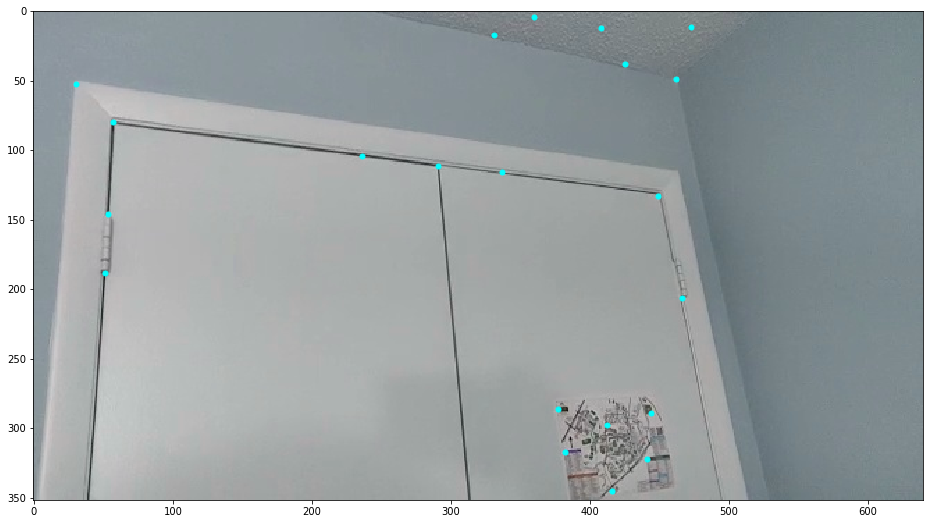

In [7]:
fig = plt.figure(0, (18, 9))
plt.imshow(img, cmap = 'gray')
plt.scatter(points[:, 0, 0], points[:,0,1], c = [[0, 1, 1]], s = 25)
plt.savefig('fig11.jpg')

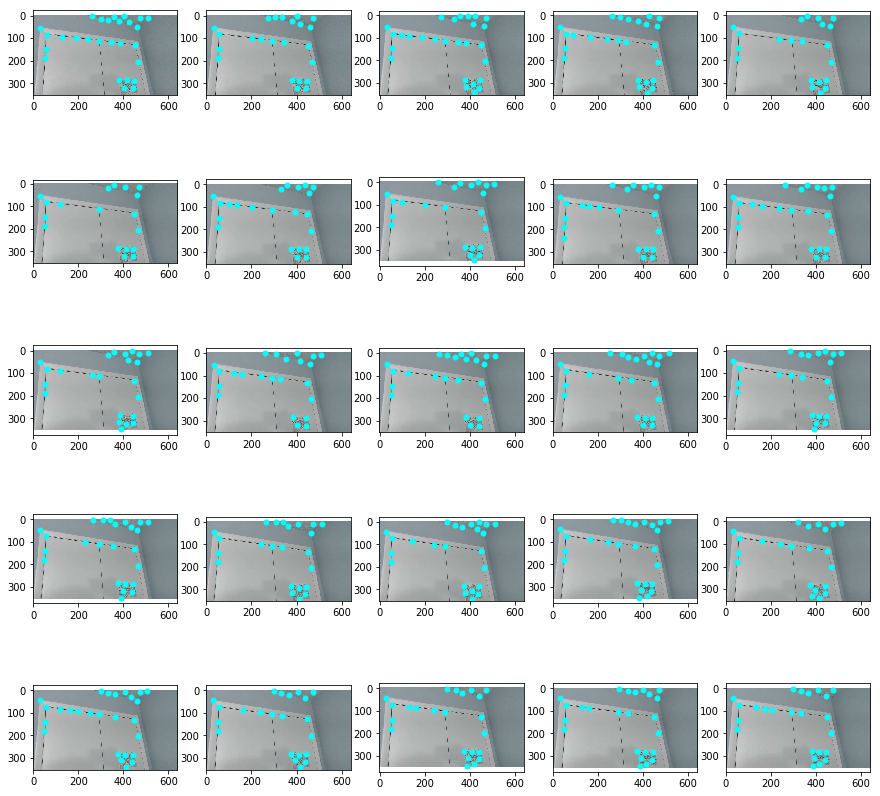

In [8]:
fig=plt.figure(figsize=(15, 15))
row = 5
column =5
for i in range(1,column*row+1):
    img = cv2.imread( './finaldata/frame' + str(i)+ '.jpg')
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    points = cv2.goodFeaturesToTrack(img_gray,maxCorners=200,qualityLevel=0.01,minDistance=30,blockSize=3)
    fig.add_subplot(row,column,i)
    plt.imshow(img, cmap = 'gray')
    plt.scatter(points[:, 0, 0], points[:,0,1], c = [[0, 1, 1]], s = 25)
plt.show()

# Model

Digital Video stabilization involves three stages: motion estimation, motion smoothing, and image composition. Due to our project involving camera motion estimation exclusively, we can perform the first stage of this process to achieve our goal. Our code finds camera motion by tracking a few key points between two frames and estimating their differences. We can test the accuracy of the transform estimation by printing our matrix and comparing with test data.

The code starts by inputting a video and defining important aspects about the video, such as size and frame amount. It then retrieves the first frame image, assigns it to “previous frame”, and creates a transformation matrix of zeros. This will become our baseline and allow us to determine how much the key points in the next frame have changed from their original position. After forming this baseline, the code begins a for loop that iterates through each frame and determines how the camera has changed.

The for loop starts by defining key points using the previous frame. It then gets the current frame and assigns it to “current”, if it is able to be read. We then check that the key points chosen in the previous frame have a valid status, meaning they are not being obscured in the current frame. After validation, the valid points are compared in both frames to determine the total rigid transformation. This transformation is then decomposed into x, y, and a rotational angle value. These values are stored in the transformation matrix and the current frame is assigned to previous frame. The loop then iterates to the next frame and repeats the process.

In [9]:
import numpy as np
import cv2
 
# Read input video
cap = cv2.VideoCapture('./data/final.mp4')
 
# Get frame count
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) 
 
# Get width and height of video stream
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) 
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
 
# Define the codec for output video
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
fps = int(cap.get(cv2.CAP_PROP_FPS))
# Set up output video
out = cv2.VideoWriter('./data/final_out.mp4', fourcc,fps,(w, h))

#find fps value 


# Read first frame
_, prev = cap.read() 
 
# Convert frame to grayscale
prev_gray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY) 

# Pre-define transformation-store array
transforms = np.zeros((n_frames-1, 3), np.float32) 
 
for i in range(n_frames-2):
  # Detect feature points in previous frame
    prev_pts = cv2.goodFeaturesToTrack(prev_gray,
                                     maxCorners=200,
                                     qualityLevel=0.01,
                                     minDistance=30,
                                     blockSize=3)

    # Read next frame
    success, curr = cap.read() 
    if not success: 
        break

    # Convert to grayscale
    curr_gray = cv2.cvtColor(curr, cv2.COLOR_BGR2GRAY) 

    # Calculate optical flow (i.e. track feature points)
    curr_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, curr_gray, prev_pts, None) 

    # Sanity check
    assert prev_pts.shape == curr_pts.shape 

    # Filter only valid points
    idx = np.where(status==1)[0]
    prev_pts = prev_pts[idx]
    curr_pts = curr_pts[idx]

    #Find transformation matrix
    m = cv2.estimateRigidTransform(prev_pts, curr_pts,fullAffine=False) 
    
    #print(m)
    # Extract traslation
    dx = m[0,2]
    dy = m[1,2]

    # Extract rotation angle
    da = np.arctan2(m[1,0], m[0,0])

    # Store transformation
    transforms[i] = [dx,dy,da]

    # Move to next frame
    prev_gray = curr_gray

    print("Frame: " + str(i) +  "/" + str(n_frames) + " -  Tracked points : " + str(len(prev_pts))+ str(transforms[i]))

Frame: 0/1940 -  Tracked points : 22[ 0.67770106 -0.23461096  0.00176571]
Frame: 1/1940 -  Tracked points : 25[ 0.27902403 -0.4294742   0.00132155]
Frame: 2/1940 -  Tracked points : 25[ 0.8719581  -1.4696544   0.00386961]
Frame: 3/1940 -  Tracked points : 25[ 0.4890186  -0.71140647  0.00147409]
Frame: 4/1940 -  Tracked points : 25[-0.8636319  -1.0099208   0.00217866]
Frame: 5/1940 -  Tracked points : 21[ 0.6890322   2.109042   -0.00265716]
Frame: 6/1940 -  Tracked points : 19[-0.1392971   0.42928374 -0.0010407 ]
Frame: 7/1940 -  Tracked points : 22[-1.0497211   0.38134566 -0.00166734]
Frame: 8/1940 -  Tracked points : 21[ 0.66220695 -0.02353809  0.00086055]
Frame: 9/1940 -  Tracked points : 20[ 0.47609586 -0.31179127  0.00151894]
Frame: 10/1940 -  Tracked points : 22[ 2.331305   -0.93884027  0.00271936]
Frame: 11/1940 -  Tracked points : 26[ 1.8650905 -1.292056   0.0037842]
Frame: 12/1940 -  Tracked points : 22[ 1.5571933 -0.7813028  0.0023504]
Frame: 13/1940 -  Tracked points : 23[ 1.

Frame: 110/1940 -  Tracked points : 25[-0.18820477 -0.6587449   0.00165496]
Frame: 111/1940 -  Tracked points : 27[ 0.9689649  -0.9329046   0.00295253]
Frame: 112/1940 -  Tracked points : 27[ 0.9176315  -0.93206125  0.00344318]
Frame: 113/1940 -  Tracked points : 28[ 1.0253239  -1.0410683   0.00313289]
Frame: 114/1940 -  Tracked points : 27[-0.26498327 -0.7459188   0.00174448]
Frame: 115/1940 -  Tracked points : 26[ 0.7269303  -0.6623732   0.00286777]
Frame: 116/1940 -  Tracked points : 27[ 1.0324326  -1.155364    0.00441662]
Frame: 117/1940 -  Tracked points : 28[ 3.1907806  -1.7898672   0.00694796]
Frame: 118/1940 -  Tracked points : 26[ 0.73490286 -2.1983871   0.00645794]
Frame: 119/1940 -  Tracked points : 28[-0.03116955 -2.6459632   0.00716037]
Frame: 120/1940 -  Tracked points : 27[ 0.47608003 -1.992806    0.00576315]
Frame: 121/1940 -  Tracked points : 26[ 0.59962875 -1.5894907   0.00516778]
Frame: 122/1940 -  Tracked points : 27[ 0.23932345 -1.1680318   0.00253918]
Frame: 123/1

Frame: 222/1940 -  Tracked points : 20[-6.4064957e-02 -6.1508584e-01  5.5249454e-04]
Frame: 223/1940 -  Tracked points : 20[ 0.13236342 -0.58258075  0.00067764]
Frame: 224/1940 -  Tracked points : 20[ 0.36772588 -0.5284648   0.00061841]
Frame: 225/1940 -  Tracked points : 21[-0.74854475  0.4055112  -0.0011875 ]
Frame: 226/1940 -  Tracked points : 20[-0.50864506  0.66056365 -0.00262216]
Frame: 227/1940 -  Tracked points : 19[-0.10409664 -0.17899758 -0.00034749]
Frame: 228/1940 -  Tracked points : 20[-0.05507217  0.0761127  -0.00031326]
Frame: 229/1940 -  Tracked points : 21[ 0.3020715  -0.37349257  0.00038552]
Frame: 230/1940 -  Tracked points : 20[ 2.3366924e-01 -2.0862158e-01 -2.3351085e-05]
Frame: 231/1940 -  Tracked points : 20[ 0.14727177 -0.01061924 -0.0003199 ]
Frame: 232/1940 -  Tracked points : 21[0.52019393 0.06151082 0.00073685]
Frame: 233/1940 -  Tracked points : 19[ 0.42397016 -0.6373269   0.00208588]
Frame: 234/1940 -  Tracked points : 19[ 0.76466113 -0.7433808   0.0024937

Frame: 342/1940 -  Tracked points : 26[ 0.74083525 -0.76303506  0.00395113]
Frame: 343/1940 -  Tracked points : 22[ 1.4267561  -0.83850574  0.00498052]
Frame: 344/1940 -  Tracked points : 25[ 2.4237478  -2.2428966   0.00849136]
Frame: 345/1940 -  Tracked points : 27[ 1.5040416  -1.8488712   0.00638862]
Frame: 346/1940 -  Tracked points : 27[ 1.0240613  -1.2339215   0.00496366]
Frame: 347/1940 -  Tracked points : 27[-0.08598205 -0.80823684  0.00286841]
Frame: 348/1940 -  Tracked points : 28[-1.1644045   0.30395263 -0.00132025]
Frame: 349/1940 -  Tracked points : 26[-2.2708936   1.2113985  -0.00292655]
Frame: 350/1940 -  Tracked points : 26[-0.9205167   1.9191552  -0.00356321]
Frame: 351/1940 -  Tracked points : 25[-9.2556852e-01  4.7721088e-01 -5.9060665e-04]
Frame: 352/1940 -  Tracked points : 26[-1.0827485e+00  4.7429854e-01 -6.4283272e-04]
Frame: 353/1940 -  Tracked points : 28[-1.1372162e+00  6.6004735e-01 -3.8740074e-04]
Frame: 354/1940 -  Tracked points : 27[-8.0674720e-01  6.5636

Frame: 463/1940 -  Tracked points : 20[-1.0561455e+00  3.7626189e-01 -4.8558775e-04]
Frame: 464/1940 -  Tracked points : 20[-4.9463034e-01  2.8318959e-01 -3.1981512e-04]
Frame: 465/1940 -  Tracked points : 20[-8.4279048e-01  1.3112995e-01 -5.3331297e-04]
Frame: 466/1940 -  Tracked points : 21[-1.3221650e+00  5.4578453e-01 -9.7113295e-04]
Frame: 467/1940 -  Tracked points : 22[-3.2224041e-01  3.5181101e-02  1.6769023e-04]
Frame: 468/1940 -  Tracked points : 25[-0.48485166 -0.00735789  0.00079815]
Frame: 469/1940 -  Tracked points : 22[ 0.17371693 -0.38155708  0.00212304]
Frame: 470/1940 -  Tracked points : 25[ 1.0167531  -0.79746497  0.00354027]
Frame: 471/1940 -  Tracked points : 23[ 0.91176313 -1.0718771   0.00367708]
Frame: 472/1940 -  Tracked points : 25[ 1.4275036  -0.88758826  0.00349552]
Frame: 473/1940 -  Tracked points : 26[ 0.13273343 -0.73920673  0.00234611]
Frame: 474/1940 -  Tracked points : 25[ 0.23786725 -1.0512697   0.00283997]
Frame: 475/1940 -  Tracked points : 22[-0.0

Frame: 583/1940 -  Tracked points : 15[ 0.71421796  0.57133627 -0.00168908]
Frame: 584/1940 -  Tracked points : 17[ 8.4374893e-01 -3.5540155e-01  4.5003599e-04]
Frame: 585/1940 -  Tracked points : 16[ 6.9506949e-01 -3.4569213e-01  5.8709487e-04]
Frame: 586/1940 -  Tracked points : 15[ 2.5182739e-01 -5.5937415e-01  3.3433724e-04]
Frame: 587/1940 -  Tracked points : 18[ 5.0124854e-01 -2.4611327e-01  4.9567735e-04]
Frame: 588/1940 -  Tracked points : 15[4.0035244e-02 1.8818498e-01 6.9707938e-05]
Frame: 589/1940 -  Tracked points : 17[-0.22023183  0.4624295  -0.00048772]
Frame: 590/1940 -  Tracked points : 17[0.7667819  0.01508658 0.00145486]
Frame: 591/1940 -  Tracked points : 21[1.1052594  0.22405353 0.00179855]
Frame: 592/1940 -  Tracked points : 20[-0.01853629  1.761198   -0.00181098]
Frame: 593/1940 -  Tracked points : 18[ 1.4646604e+00  2.4811769e+00 -2.1057518e-03]
Frame: 594/1940 -  Tracked points : 20[-1.2466005   1.115234   -0.00279446]
Frame: 595/1940 -  Tracked points : 19[ 0.7

Frame: 703/1940 -  Tracked points : 43[-0.5987488   0.11429335 -0.00077225]
Frame: 704/1940 -  Tracked points : 43[ 0.13228993 -0.00797668 -0.00097752]
Frame: 705/1940 -  Tracked points : 47[ 0.01330911 -0.46438718  0.00127745]
Frame: 706/1940 -  Tracked points : 45[ 1.1145285  -0.19968387  0.00121107]
Frame: 707/1940 -  Tracked points : 43[ 0.45425695 -2.164794    0.00484881]
Frame: 708/1940 -  Tracked points : 44[ 0.32875615 -1.067958    0.00283898]
Frame: 709/1940 -  Tracked points : 46[ 0.15533014 -0.9042812   0.00244106]
Frame: 710/1940 -  Tracked points : 45[-2.2322893e-01 -4.1406351e-01  2.2076719e-04]
Frame: 711/1940 -  Tracked points : 46[-0.0065374   0.04404077 -0.00063096]
Frame: 712/1940 -  Tracked points : 47[-0.5605348   0.14376494 -0.00071937]
Frame: 713/1940 -  Tracked points : 44[-0.34077826  0.29634553 -0.00140818]
Frame: 714/1940 -  Tracked points : 45[-0.08538292 -0.04441398 -0.00076221]
Frame: 715/1940 -  Tracked points : 48[-0.98793304  0.14156665 -0.00109553]
Fra

Frame: 821/1940 -  Tracked points : 25[ 0.53172606  1.4083427  -0.00429958]
Frame: 822/1940 -  Tracked points : 26[ 0.41693023  2.1578758  -0.00556561]
Frame: 823/1940 -  Tracked points : 30[-0.2752443   2.223537   -0.00736331]
Frame: 824/1940 -  Tracked points : 27[ 0.05632368  1.9756153  -0.00670073]
Frame: 825/1940 -  Tracked points : 24[ 1.0348504   1.1601746  -0.00330452]
Frame: 826/1940 -  Tracked points : 24[-1.6475412   0.15012343 -0.00217629]
Frame: 827/1940 -  Tracked points : 28[ 1.0843713e+00 -5.4312086e-01  3.5917695e-04]
Frame: 828/1940 -  Tracked points : 25[ 0.8053459   0.10215686 -0.00151264]
Frame: 829/1940 -  Tracked points : 24[-0.23631069  0.7033687  -0.00347882]
Frame: 830/1940 -  Tracked points : 23[-0.27390403  2.6316166  -0.00700036]
Frame: 831/1940 -  Tracked points : 21[ 2.1337752   2.50327    -0.00601547]
Frame: 832/1940 -  Tracked points : 21[ 0.49958932  0.839451   -0.00165659]
Frame: 833/1940 -  Tracked points : 23[ 0.672246   -1.0854332   0.00161541]
Fra

Frame: 943/1940 -  Tracked points : 29[ 0.4082738   1.2109773  -0.00585147]
Frame: 944/1940 -  Tracked points : 27[ 1.7421302   0.40894723 -0.00256341]
Frame: 945/1940 -  Tracked points : 27[ 0.80832654  0.42401728 -0.0027781 ]
Frame: 946/1940 -  Tracked points : 24[ 1.7452325e+00 -7.5370538e-01  1.5916819e-03]
Frame: 947/1940 -  Tracked points : 25[ 0.23534444  0.2019488  -0.00083367]
Frame: 948/1940 -  Tracked points : 30[ 0.71112865 -0.8187013   0.00144854]
Frame: 949/1940 -  Tracked points : 29[ 2.567527e-01 -3.888351e-01  2.969776e-04]
Frame: 950/1940 -  Tracked points : 29[-0.63974893 -0.08277693 -0.00065512]
Frame: 951/1940 -  Tracked points : 28[ 1.6949904e+00 -1.1234760e+00  1.3423642e-03]
Frame: 952/1940 -  Tracked points : 22[-0.02472139  0.11746754 -0.00074079]
Frame: 953/1940 -  Tracked points : 24[-0.5532011   0.5427688  -0.00153313]
Frame: 954/1940 -  Tracked points : 23[-1.3915634e-01  5.0287378e-01 -4.9691251e-04]
Frame: 955/1940 -  Tracked points : 22[0.27879384 0.143

Frame: 1060/1940 -  Tracked points : 26[-0.6151399   1.1461173  -0.00412629]
Frame: 1061/1940 -  Tracked points : 29[ 0.16505766  0.20044948 -0.00109584]
Frame: 1062/1940 -  Tracked points : 30[ 4.5051876e-01 -8.6447196e-03 -8.4569947e-05]
Frame: 1063/1940 -  Tracked points : 28[-2.2403973e-01  1.0931925e-02 -1.1224177e-04]
Frame: 1064/1940 -  Tracked points : 29[-0.72116077  0.7550405  -0.00224965]
Frame: 1065/1940 -  Tracked points : 28[-0.6434538   0.4260252  -0.00141757]
Frame: 1066/1940 -  Tracked points : 29[-0.30657798  0.3069104  -0.0011002 ]
Frame: 1067/1940 -  Tracked points : 29[-0.10690107  0.08005143 -0.0002702 ]
Frame: 1068/1940 -  Tracked points : 28[ 0.80348235 -0.11506215  0.00140769]
Frame: 1069/1940 -  Tracked points : 32[ 0.6453097  -1.0031335   0.00350822]
Frame: 1070/1940 -  Tracked points : 29[ 1.177033   -1.5610762   0.00521844]
Frame: 1071/1940 -  Tracked points : 29[ 1.5995065  -0.9435518   0.00430155]
Frame: 1072/1940 -  Tracked points : 30[ 0.24192515 -0.864

Frame: 1178/1940 -  Tracked points : 33[ 0.15237214  0.34173885 -0.00081433]
Frame: 1179/1940 -  Tracked points : 35[-0.00402979 -0.16105874 -0.00126174]
Frame: 1180/1940 -  Tracked points : 31[-0.37316883  0.11049861 -0.00132009]
Frame: 1181/1940 -  Tracked points : 32[-0.4018091   0.43217462 -0.00173861]
Frame: 1182/1940 -  Tracked points : 34[-0.18886858  0.38467622 -0.00166463]
Frame: 1183/1940 -  Tracked points : 31[ 7.1550429e-02 -3.9741218e-01 -2.2482520e-04]
Frame: 1184/1940 -  Tracked points : 32[-0.21268371  0.08890241 -0.00107969]
Frame: 1185/1940 -  Tracked points : 33[ 0.57194245 -0.06429003 -0.00076892]
Frame: 1186/1940 -  Tracked points : 35[ 0.21314876 -0.37873185 -0.00062195]
Frame: 1187/1940 -  Tracked points : 32[-0.53924906  0.5257055  -0.00182191]
Frame: 1188/1940 -  Tracked points : 32[-0.0625989   0.19877237 -0.00033979]
Frame: 1189/1940 -  Tracked points : 33[ 0.42924315 -0.02232259 -0.0004709 ]
Frame: 1190/1940 -  Tracked points : 33[ 1.0562375e+00 -5.7044798e-

Frame: 1295/1940 -  Tracked points : 29[ 0.54083073 -0.6631927   0.00277507]
Frame: 1296/1940 -  Tracked points : 30[ 0.6031203  -1.0598155   0.00285502]
Frame: 1297/1940 -  Tracked points : 31[ 0.18862589 -0.593262    0.00172313]
Frame: 1298/1940 -  Tracked points : 33[ 0.43403766 -1.5503039   0.00350286]
Frame: 1299/1940 -  Tracked points : 27[ 0.12563159 -1.1559476   0.00295353]
Frame: 1300/1940 -  Tracked points : 28[-0.2867975  -0.5271725   0.00151841]
Frame: 1301/1940 -  Tracked points : 27[ 0.27461395 -0.50175095  0.00198221]
Frame: 1302/1940 -  Tracked points : 27[ 0.30511633 -1.0624396   0.00215369]
Frame: 1303/1940 -  Tracked points : 31[-1.7272072e-01 -4.3671420e-01  1.7902502e-04]
Frame: 1304/1940 -  Tracked points : 31[-0.22765215 -0.17143114  0.00025048]
Frame: 1305/1940 -  Tracked points : 28[-0.08714558 -0.25297803  0.00099986]
Frame: 1306/1940 -  Tracked points : 27[ 0.21898623 -0.41718355  0.00156988]
Frame: 1307/1940 -  Tracked points : 28[ 0.32094127 -0.56104     0.

Frame: 1413/1940 -  Tracked points : 35[-0.48672423  0.10692511  0.00089061]
Frame: 1414/1940 -  Tracked points : 33[-0.3615197   0.21080089  0.00048815]
Frame: 1415/1940 -  Tracked points : 34[ 1.2393204  -0.6808278   0.00302109]
Frame: 1416/1940 -  Tracked points : 33[ 0.25582638 -0.45852527  0.00188527]
Frame: 1417/1940 -  Tracked points : 33[ 0.19105464 -0.91587996  0.00313217]
Frame: 1418/1940 -  Tracked points : 33[ 0.03870577 -0.5055602   0.00232918]
Frame: 1419/1940 -  Tracked points : 31[ 0.3236898  -0.5658909   0.00259787]
Frame: 1420/1940 -  Tracked points : 32[-1.4369794  -1.0643649   0.00253768]
Frame: 1421/1940 -  Tracked points : 30[ 0.51056045 -1.3033661   0.00343993]
Frame: 1422/1940 -  Tracked points : 32[-0.09763823 -0.4604632   0.00202006]
Frame: 1423/1940 -  Tracked points : 31[-0.291007   -1.0388788   0.00323019]
Frame: 1424/1940 -  Tracked points : 32[-0.04099924 -1.2849269   0.00395912]
Frame: 1425/1940 -  Tracked points : 34[-0.02809381 -0.5027572   0.00321222]

Frame: 1532/1940 -  Tracked points : 20[-1.390011   0.738893  -0.0024594]
Frame: 1533/1940 -  Tracked points : 20[-0.22622447 -3.328739    0.00806524]
Frame: 1534/1940 -  Tracked points : 21[-4.8179686e-01  1.7191109e-01  8.2403320e-05]
Frame: 1535/1940 -  Tracked points : 20[ 2.4427981  -1.2458913   0.00588942]
Frame: 1536/1940 -  Tracked points : 19[ 1.4361819  -0.66515183  0.00370639]
Frame: 1537/1940 -  Tracked points : 18[ 0.7314824  -0.01318853  0.0019433 ]
Frame: 1538/1940 -  Tracked points : 20[1.8310866  0.35140055 0.00224058]
Frame: 1539/1940 -  Tracked points : 19[-2.5045466e-01  5.2811182e-01  2.1702817e-04]
Frame: 1540/1940 -  Tracked points : 22[-2.3081203   0.77526706 -0.00250253]
Frame: 1541/1940 -  Tracked points : 21[-3.6107230e+00  9.6535605e-01 -3.5531409e-03]
Frame: 1542/1940 -  Tracked points : 21[-1.5187359   1.6172494  -0.00315302]
Frame: 1543/1940 -  Tracked points : 19[-2.0505693  -1.8289711   0.00353296]
Frame: 1544/1940 -  Tracked points : 19[-3.0308850e+00 

Frame: 1650/1940 -  Tracked points : 21[ 1.6578060e+00 -7.7561623e-01  1.2769712e-03]
Frame: 1651/1940 -  Tracked points : 20[ 8.241684e-01 -7.843487e-01  7.137020e-04]
Frame: 1652/1940 -  Tracked points : 21[ 1.9376444  -0.8219675   0.00204334]
Frame: 1653/1940 -  Tracked points : 19[ 2.0773668e+00 -7.2790378e-01  1.6281185e-03]
Frame: 1654/1940 -  Tracked points : 19[ 2.2648952  -0.8575705   0.00226573]
Frame: 1655/1940 -  Tracked points : 22[ 1.7637450e+00 -5.0901908e-01  1.1600002e-03]
Frame: 1656/1940 -  Tracked points : 23[ 0.75100446 -0.12209767 -0.00079881]
Frame: 1657/1940 -  Tracked points : 22[ 0.53351027 -0.1190405  -0.00081426]
Frame: 1658/1940 -  Tracked points : 23[-1.2931168  -0.05129576 -0.00229714]
Frame: 1659/1940 -  Tracked points : 22[ 4.1821694e-01 -1.8424900e-01  3.2802065e-05]
Frame: 1660/1940 -  Tracked points : 22[ 1.9141653  -1.738283    0.00423772]
Frame: 1661/1940 -  Tracked points : 21[ 7.2955394e-01 -1.4148763e-01  1.2865839e-04]
Frame: 1662/1940 -  Track

Frame: 1770/1940 -  Tracked points : 25[ 0.4689312  -0.12846296  0.00086719]
Frame: 1771/1940 -  Tracked points : 25[ 2.1182947e-01  5.3524550e-02 -1.2863163e-04]
Frame: 1772/1940 -  Tracked points : 26[ 0.4514194  -0.25926223  0.00089691]
Frame: 1773/1940 -  Tracked points : 26[7.2631288e-01 1.9101502e-02 4.7925746e-04]
Frame: 1774/1940 -  Tracked points : 25[ 1.0881673e+00  2.3511446e-01 -8.2150145e-05]
Frame: 1775/1940 -  Tracked points : 26[ 3.1139941e+00 -4.8761842e-01  1.9583001e-03]
Frame: 1776/1940 -  Tracked points : 24[-0.44891125 -0.03905299 -0.00149023]
Frame: 1777/1940 -  Tracked points : 25[-0.29432225  0.15316172 -0.00201789]
Frame: 1778/1940 -  Tracked points : 26[-0.09455021  0.07592356 -0.00103188]
Frame: 1779/1940 -  Tracked points : 25[ 1.6296253e+00 -1.9846529e-01  6.6645292e-04]
Frame: 1780/1940 -  Tracked points : 26[ 1.8210950e+00 -4.4629008e-01  1.5543496e-03]
Frame: 1781/1940 -  Tracked points : 25[ 3.3757789e+00 -3.4977221e-01  2.2737954e-03]
Frame: 1782/1940

Frame: 1889/1940 -  Tracked points : 19[ 3.2811303  -1.5903165   0.00715967]
Frame: 1890/1940 -  Tracked points : 18[ 5.990457   -1.0272188   0.01005735]
Frame: 1891/1940 -  Tracked points : 19[ 4.0627646  -0.3948028   0.00674051]
Frame: 1892/1940 -  Tracked points : 19[ 3.86798    -1.7513565   0.00708107]
Frame: 1893/1940 -  Tracked points : 19[ 6.510209   -1.0867718   0.00966964]
Frame: 1894/1940 -  Tracked points : 17[ 4.95892    -1.2501045   0.00691194]
Frame: 1895/1940 -  Tracked points : 18[ 2.617328   -2.096645    0.00661601]
Frame: 1896/1940 -  Tracked points : 19[ 4.1038256  -1.8204702   0.00916691]
Frame: 1897/1940 -  Tracked points : 18[ 2.02021    -1.6773806   0.00599156]
Frame: 1898/1940 -  Tracked points : 16[ 3.0157409  -2.6786635   0.00986892]
Frame: 1899/1940 -  Tracked points : 19[-0.19450457 -1.3589451   0.00364289]
Frame: 1900/1940 -  Tracked points : 20[ 1.9336624  -0.9263795   0.00393722]
Frame: 1901/1940 -  Tracked points : 16[ 0.7659003  -0.85731775  0.00269661]

## Smoothing

In [10]:
trajectory = np.cumsum(transforms, axis=0) 

In [11]:
def movingAverage(curve, radius): 
    window_size = 2 * radius + 1
  # Define the filter 
    f = np.ones(window_size)/window_size 
  # Add padding to the boundaries 
    curve_pad = np.lib.pad(curve, (radius, radius), 'edge') 
  # Apply convolution 
    curve_smoothed = np.convolve(curve_pad, f, mode='same') 
  # Remove padding 
    curve_smoothed = curve_smoothed[radius:-radius]
  # return smoothed curve
    return curve_smoothed 

def smooth(trajectory,SMOOTHING_RADIUS): 
    smoothed_trajectory = np.copy(trajectory) 
  # Filter the x, y and z
    for i in range(3):
        smoothed_trajectory[:,i] = movingAverage(trajectory[:,i], radius=SMOOTHING_RADIUS)
 
    return smoothed_trajectory



In [12]:
smoothed_trajectory = smooth(trajectory,2)

# Calculate difference in smoothed_trajectory and trajectory
difference = smoothed_trajectory - trajectory
  
# Calculate newer transformation array
transforms_smooth = transforms + difference

In [13]:
transforms_smooth[:,2]

array([ 3.0682515e-03,  2.6355898e-03,  3.0828256e-03, ...,
       -4.2856555e-05,  2.7984084e-04, -4.4882298e-05], dtype=float32)

In [15]:
ans = []
for i in range(1,len(transforms_smooth)):
    if (i+1)%30 == 0:
        ans.append(transforms_smooth[i])
ans       

[array([-1.5903043 ,  0.5767007 , -0.00264369], dtype=float32),
 array([-0.7158512 ,  3.180838  , -0.00834852], dtype=float32),
 array([-0.7233398 , -0.22384623,  0.00092002], dtype=float32),
 array([ 0.1446756 , -2.26292   ,  0.00634346], dtype=float32),
 array([ 0.4411014 ,  0.5021429 , -0.00187328], dtype=float32),
 array([-0.26493892,  0.54845333, -0.00199729], dtype=float32),
 array([ 0.19726384, -0.9375335 ,  0.00159047], dtype=float32),
 array([ 1.2978520e+00, -1.2782308e-01,  8.2048750e-04], dtype=float32),
 array([2.4138504e-01, 1.4851743e-01, 2.1454768e-04], dtype=float32),
 array([ 0.90314114, -1.2781377 ,  0.00490061], dtype=float32),
 array([ 0.26533008, -0.60916823,  0.00309437], dtype=float32),
 array([ 2.0496435 , -1.8792429 ,  0.00716773], dtype=float32),
 array([ 2.5702577e+00, -8.7057632e-01,  3.1075120e-04], dtype=float32),
 array([-0.8763518 ,  0.6711444 , -0.00125164], dtype=float32),
 array([-0.25789875, -2.7465081 ,  0.00595974], dtype=float32),
 array([-6.94014

## Result

In [14]:
# warning: this csv contains wrong data
import csv
with open('./data/OV.csv',"rt") as f:
    reader = csv.reader(f,delimiter=',')
    y_list = list(reader)
y = np.array(y_list,dtype='float32')
y

array([[ 1.3000e-02,  5.5400e-02,  9.9960e-01,  3.6200e-02,  1.0000e+00],
       [ 1.0000e+00,  1.5600e-02,  9.8660e-01,  1.1780e-01,  9.9000e-01],
       [ 2.0080e+00,  3.8300e-02,  9.8840e-01,  1.1290e-01,  1.0000e+00],
       [ 3.0090e+00,  2.7600e-02,  9.8570e-01,  1.5000e-01,  1.0000e+00],
       [ 4.0180e+00, -1.1970e-01,  9.7540e-01,  1.2120e-01,  9.9000e-01],
       [ 5.0170e+00, -2.8400e-02,  9.6810e-01,  1.3170e-01,  9.8000e-01],
       [ 6.0090e+00,  9.3800e-02,  9.9060e-01,  8.9700e-02,  1.0000e+00],
       [ 7.0080e+00,  1.1530e-01,  9.7420e-01,  1.0120e-01,  9.9000e-01],
       [ 8.0070e+00,  2.4600e-01,  9.4290e-01,  4.8400e-02,  9.8000e-01],
       [ 9.0060e+00,  7.0600e-02,  9.9540e-01,  9.1700e-02,  1.0000e+00],
       [ 1.0004e+01,  5.8600e-02,  9.7660e-01,  1.5050e-01,  9.9000e-01],
       [ 1.1016e+01,  3.5400e-02,  9.6860e-01,  1.5000e-01,  9.8000e-01],
       [ 1.2004e+01,  9.0600e-02,  1.0174e+00, -4.3700e-02,  1.0200e+00],
       [ 1.3028e+01,  5.4200e-02,  9.7

In [29]:
def output_1(no,y):
    count = 1
    temp = []
    t = [y[i][no+1] for i in range(len(y))]
    for i in t:
        temp.append(i*count)
        count+=1
    return temp

In [30]:
def output(no):
    yhat = []
    for i in ans:
        yhat.append(i[no])
    yhat = np.array(yhat)
    return yhat

## Ploting the Result

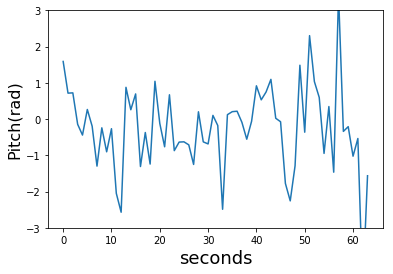

<Figure size 432x288 with 0 Axes>

In [31]:
fig = plt.figure()
x = output_1(0,y)
xhat = output(0)
plt.xlabel('seconds', fontsize=18)
plt.ylabel('Pitch(rad)', fontsize=16)
plt.ylim(-3,3)
#plt.plot(y[:,1])
#plt.plot(smoothed_trajectory[:,0])
plt.plot(xhat*-1)
plt.show()
plt.savefig('fig1.jpg')

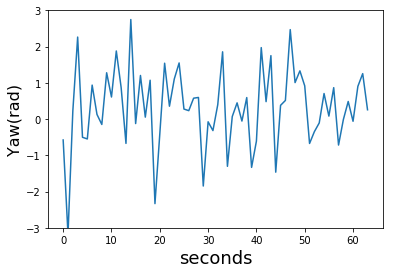

<Figure size 432x288 with 0 Axes>

In [32]:
fig = plt.figure()
ty = output_1(1,y)
yhat = output(1)
plt.xlabel('seconds', fontsize=18)
plt.ylabel('Yaw(rad)', fontsize=16)
#plt.plot(1-y[:,2])
plt.ylim(-3,3)
#plt.plot(smoothed_trajectory[:,1])
plt.plot(yhat*-1)
plt.show()
plt.savefig('fig2.jpg')

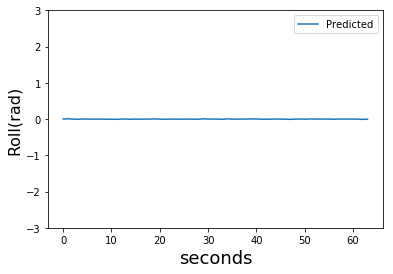

<Figure size 432x288 with 0 Axes>

In [33]:
fig = plt.figure()
z = output_1(2,y)
zhat = output(2)
plt.xlabel('seconds', fontsize=18)
plt.ylabel('Roll(rad)', fontsize=16)
plt.ylim(-3,3)
#plt.plot(y[:,3],label='Actual')
#plt.plot(smoothed_trajectory[:,2])
plt.plot(zhat*-1,label = 'Predicted')
plt.legend()
plt.show()
plt.savefig('fig3.jpg')

## OutputVideo

In [34]:
def fixBorder(frame):
    s = frame.shape
  # Scale the image 4% without moving the center
    T = cv2.getRotationMatrix2D((s[1]/2, s[0]/2), 0, 1.04)
    frame = cv2.warpAffine(frame, T, (s[1], s[0]))
    return frame

In [35]:
# Reset stream to first frame 
cap.set(cv2.CAP_PROP_POS_FRAMES, 0) 
count = 0

ans_frame = []

# Write n_frames-1 transformed frames
for i in range(n_frames-2):
  # Read next frame
    success, frame = cap.read() 
    if not success:
        break
 
  # Extract transformations from the new transformation array
    dx = transforms_smooth[i,0]
    dy = transforms_smooth[i,1]
    da = transforms_smooth[i,2]
 
  # Reconstruct transformation matrix accordingly to new values
    m = np.zeros((2,3), np.float32)
    m[0,0] = np.cos(da)
    m[0,1] = -np.sin(da)
    m[1,0] = np.sin(da)
    m[1,1] = np.cos(da)
    m[0,2] = dx
    m[1,2] = dy
 
  # Apply affine wrapping to the given frame
    frame_stabilized = cv2.warpAffine(frame, m, (w,h))
    #print(frame_stabilized)
 
  # Fix border artifacts
    frame_stabilized = fixBorder(frame_stabilized) 
 
  # Write the frame to the file
    frame_out = cv2.hconcat([frame, frame_stabilized])
 
  # If the image is too big, resize it.
    if(frame_out.shape[1]< 1920): 
        frame_out = cv2.resize(frame_out, (int(frame_out.shape[1]/2), int(frame_out.shape[0]/2)));
#     print('What is happening')
#     print(frame_out)
    ans_frame.append(frame_out)
    count+=1
#     cv2.imshow("Before and After", frame_out)
#     cv2.waitKey(10)
    out.write(frame_out)


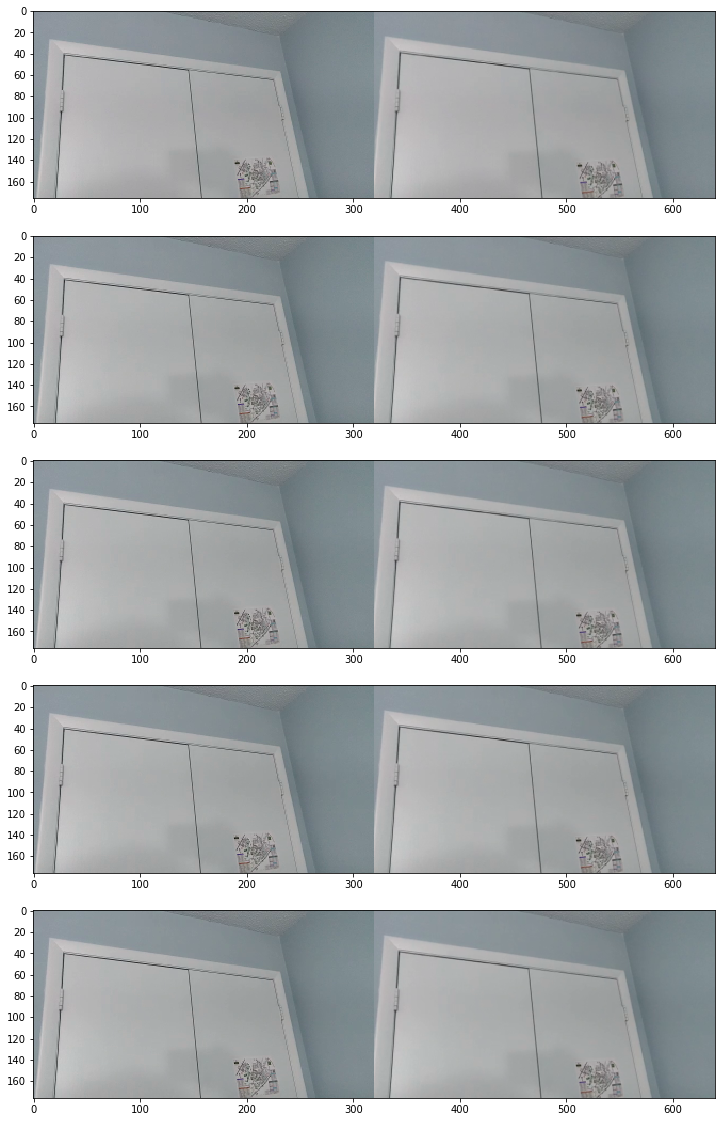

In [36]:
fig= plt.figure(figsize=(20, 20))
row = 5
col = 1
for i in range(row*col):
    fig.add_subplot(row,col,i+1)
    plt.imshow(ans_frame[i])
plt.show()

# Kalman Filter

1) To solve our main problem which was to take noisy sensor data and make it clean and smooth. The best way to do that is used kalman filter.

2) The Kalman filter is widely used in present robotics such as guidance, navigation, and control of vehicles, particularly aircraft and spacecraft. This is essential for motion planning and controlling of field robotics, and also for trajectory optimization. Further, this is used for modeling the control of movements of central nervous systems. The algorithm works in a two-step process.

    1) Prediction

    2) Estimation
In the prediction step, the filter produces estimates of the current state, along with their error probabilities. At the start, initial conditions are used. Once the next raw sensor reading is entered to the filter, these estimates are updated using a weighted average of the raw readings, with more weight being given to estimates with higher certainty.

3) After estimating the current position by the previous equation, now it's compared with the actual sensor data to get the optimum output. As a result of this, noises and errors of the raw sensor readings are removed. Basically, we can get a smooth output using a spiky input of readings.

4) We can define the sensor readings as a Gaussian distribution, as shown in the image. The readings are distributed according to the graph and most of the readings are equal to the mean value.

In [22]:
def Kalman_Filter() :
    for n in range(measurements):
        x = A*x+B*u[n]
        P = A*P*A.T + Q
 

 # Compute the Kalman Gain
    S = H*P*H.T + R
    K = (P*H.T) * np.linalg.pinv(S)

# Update the estimate via z
    Z = mx[n]
    y = Z - (H*x) # Innovation or Residual
    x = x + (K*y)
 
 # Update the error covariance
    P = (I - (K*H))*P

As you can see there are lots of variables to figure out. That is the biggest challange to set values for all attributes.

First of all x which will be intial state matrix. Like if you are predicting position and velocity. It will look like 
<img src="./data/1.jpg">

Then B is control matrix which has data regarding accerlation.

A is very key matrix which calls dynamic matrix, which works like pyshics equation which we want to implement. For example: X(final) = X(intial) + VT. It will look like this.
<img src="./data/2.jpg">

P is covariance matrix in which you can value as per how much confident you have in the sensors. If you think sensor data is bad then you can give large value and other way around. 
<img src="./data/3.jpg">

H is mesurment matrix which used to convert all the mesurements like velocity, distance in standard metric.
<img src='./data/4.jpg'>

R is Measurement noise covariance matrix, which has same perpusoe as P for reducing error in mersuring metric. The value is also depend on how confident you are on your sensors.
<img src= './data/5.jpg'>

Z is current state's sensor mesurment data. 

The u matrix will contain the robotic input of the system which could be the instantaneous acceleration or the distance traveled by the system from a IMU.

We are predict kalman gain for each cycle K. The Kalman Gain will decrease if the readings (measurements) match the predicted system state. If the measured values say otherwise, the elements of matrix K become larger.

We can represen this whole cycle by diven below. 

<img src= './data/6.jpg'>

This cycle will run permentaly till data is coming from the sensor.